# Lightgbm

In [4]:
from data.preprocessed_data import preprocessed_data
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report,  confusion_matrix
from bayes_opt import BayesianOptimization
import lightgbm
import matplotlib.pyplot as plt

## BayesianOptimization with StratifiedKFold

In [10]:
def test_lgbm_kfold(data):
    def lgbm_cv(
    max_depth,
    learning_rate,
    n_estimators,
    subsample,
    colsample_bytree,
    ):
        model = lightgbm.LGBMClassifier(
            max_depth=int(max_depth),
            learning_rate=learning_rate,
            n_estimators=int(n_estimators),
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            verbose=-1,
            random_state=0,
        )
        accs = []
        stratified_k_fold = StratifiedKFold(random_state=0, shuffle=True)
        for (train_index, test_index) in stratified_k_fold.split(data, data.Churn):
            temp = data.iloc[train_index]
            test = data.iloc[test_index]
            train, valid = train_test_split(temp, test_size=len(test)/len(temp))

            model.fit(
                train.drop(columns=['Churn']), train['Churn'],
                eval_set=[(valid.drop(columns=['Churn']), valid['Churn'])],
            )

            accuracy = model.score(
                test.drop(columns=['Churn']), test['Churn'],
            )
            accs.append(accuracy)

        return sum(accs) / len(accs)

    pbounds = {
        'max_depth': (3, 20),
        'learning_rate': (0.0001, 0.7),
        'n_estimators': (50, 1000),
        'subsample': (0.1, 1),
        'colsample_bytree': (0.2, 1),
    }

    lgbm_bayesian_optimization = BayesianOptimization(
        f=lgbm_cv,
        pbounds=pbounds,
        verbose=-1,
        random_state=0,
    )

    lgbm_bayesian_optimization.maximize(
        init_points=10,
        n_iter=50
    )

    best_params = lgbm_bayesian_optimization.max.get('params')
    best_params.update({
        'max_depth': int(best_params.get('max_depth')),
        'n_estimators': int(best_params.get('n_estimators')),
    })
    print(best_params)
    print('='*100)
    reports = {}
    confusion_mt = {}

    stratified_k_fold = StratifiedKFold(random_state=0, shuffle=True)
    for i, (train_index, test_index) in enumerate(stratified_k_fold.split(data, data.Churn)):
        temp = data.iloc[train_index]
        test = data.iloc[test_index]
        train, valid = train_test_split(temp, test_size=len(test)/len(temp))
        lgbm = lightgbm.LGBMClassifier(
            **best_params,
            verbose=-1,
            random_state=0,
        )
        lgbm.fit(
            train.drop(columns=['Churn']), train['Churn'],
            eval_set=[(valid.drop(columns=['Churn']), valid['Churn'])],
        )
        lgbm_predict = lgbm.predict(test.drop(columns=['Churn']))
        acc = lgbm.score(test.drop(columns=['Churn']), test['Churn'])

        confusion_matrix_result = confusion_matrix(
            np.where(test.Churn==0, 1, 0),
            np.where(lgbm.predict(test.drop(columns=['Churn']))==0, 1, 0),
        )
        TP = confusion_matrix_result[0, 0]
        FN = confusion_matrix_result[0, 1]
        FP = confusion_matrix_result[1, 0]
        TN = confusion_matrix_result[1, 1]

        precision = TP / (TP+FP)
        recall = TP / (TP+FN)
        f1 = 2*precision*recall / (precision+recall)
        accuracy = (TP+TN) / (TP+TN+FP+FN)

        confusion_mt.update({
            f'fold: {i+1}': {
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'accuracy': accuracy,
            }
        })

        reports.update({
            f'fold: {i+1}':{
                classification_report(test['Churn'], lgbm_predict)
            }
        })

    return confusion_mt, reports

In [5]:
data = pd.read_csv('./data/train.csv')

### 데이터셋 준비

In [6]:
# 1. 모든 Nan값 없앤 데이터
drop_na_data = preprocessed_data(data)
# 2. Nan을 해당 컬럼의 Median값으로 채움
fill_na_data = preprocessed_data(data, True)
# 3. 2번 데이터에 일부 연속형데이터를 범주형으로 변환
cat_data = preprocessed_data(data, is_fillna=True, con_to_cat=True)
# 4. 2번 데이터에 클러스터링을 통한 라벨 feature추가
cluster_data = preprocessed_data(data, is_fillna=True, clustering=True)


In [11]:
results = {}
drop_na_confusion_mts, drop_na_reorts = test_lgbm_kfold(drop_na_data)
fill_na_confusion_mts, fill_na_reorts = test_lgbm_kfold(fill_na_data)
cat_data_confusion_mts, cat_data_reorts = test_lgbm_kfold(cat_data)
cluster_confusion_mts, cluster_reorts = test_lgbm_kfold(cluster_data)

results.update({
    'drop_na': (drop_na_confusion_mts, drop_na_reorts),
    'fill_na_median': (fill_na_confusion_mts, fill_na_reorts),
    'continus_to_cat': (cat_data_confusion_mts, cat_data_reorts),
    'clustering_label': (cluster_confusion_mts, cluster_reorts)
})

|   iter    |  target   | colsam... | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------
| 1         | 0.6897    | 0.6391    | 0.5007    | 13.25     | 567.6     | 0.4813    |
| 2         | 0.7013    | 0.7167    | 0.3064    | 18.16     | 965.5     | 0.4451    |
| 3         | 0.6987    | 0.8334    | 0.3703    | 12.66     | 929.3     | 0.1639    |
| 4         | 0.7246    | 0.2697    | 0.01425   | 17.15     | 789.2     | 0.883     |
| 5         | 0.6925    | 0.9829    | 0.5594    | 10.85     | 791.5     | 0.2064    |
| 6         | 0.7205    | 0.7119    | 0.1004    | 19.06     | 545.8     | 0.4732    |
| 7         | 0.6858    | 0.4116    | 0.542     | 10.75     | 590.0     | 0.1169    |
| 8         | 0.6963    | 0.6941    | 0.4285    | 13.49     | 946.6     | 0.7136    |
| 9         | 0.7097    | 0.4876    | 0.306     | 14.86     | 107.2     | 0.7001    |
| 10        | 0.718     | 0.7365    | 0.1473    | 5.19

In [12]:
for key, value in results.items():
    print('='*100)
    print('='*100)
    print(f"lgbm result BayesianOptimization, 'StratifiedKFold, {key}")
    print('='*100)
    for fold, result in value[0].items():
        print(f'{fold}: {result}')

    print('='*100)

    for fold, result in value[1].items():
        print(f'{fold}')
        for r in result:
            print(r)
        print('='*100)

xgb result BayesianOptimization, 'StratifiedKFold, drop_na
fold: 1: {'precision': 0.5974304068522484, 'recall': 0.09792909792909793, 'f1': 0.16827503015681544, 'accuracy': 0.7228419254346297}
fold: 2: {'precision': 0.5863539445628998, 'recall': 0.09652509652509653, 'f1': 0.16576250753465943, 'accuracy': 0.7218370013064014}
fold: 3: {'precision': 0.6024096385542169, 'recall': 0.1053001053001053, 'f1': 0.179265013444876, 'accuracy': 0.7239195979899498}
fold: 4: {'precision': 0.6173361522198731, 'recall': 0.10249210249210249, 'f1': 0.1757977122215533, 'accuracy': 0.724824120603015}
fold: 5: {'precision': 0.6106382978723405, 'recall': 0.10073710073710074, 'f1': 0.1729436577282314, 'accuracy': 0.7241206030150754}
fold: 1
              precision    recall  f1-score   support

           0       0.73      0.97      0.83      7102
           1       0.60      0.10      0.17      2849

    accuracy                           0.72      9951
   macro avg       0.66      0.54      0.50      9951
we

#### Feature Importance


##### recall이 가장 높은 데이터의 Feature importance 확인

In [7]:
best_param = {'colsample_bytree': 0.3616380317466008, 'learning_rate': 0.02260902402205512, 'max_depth': 17, 'n_estimators': 789, 'subsample': 0.9677975232207768}

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

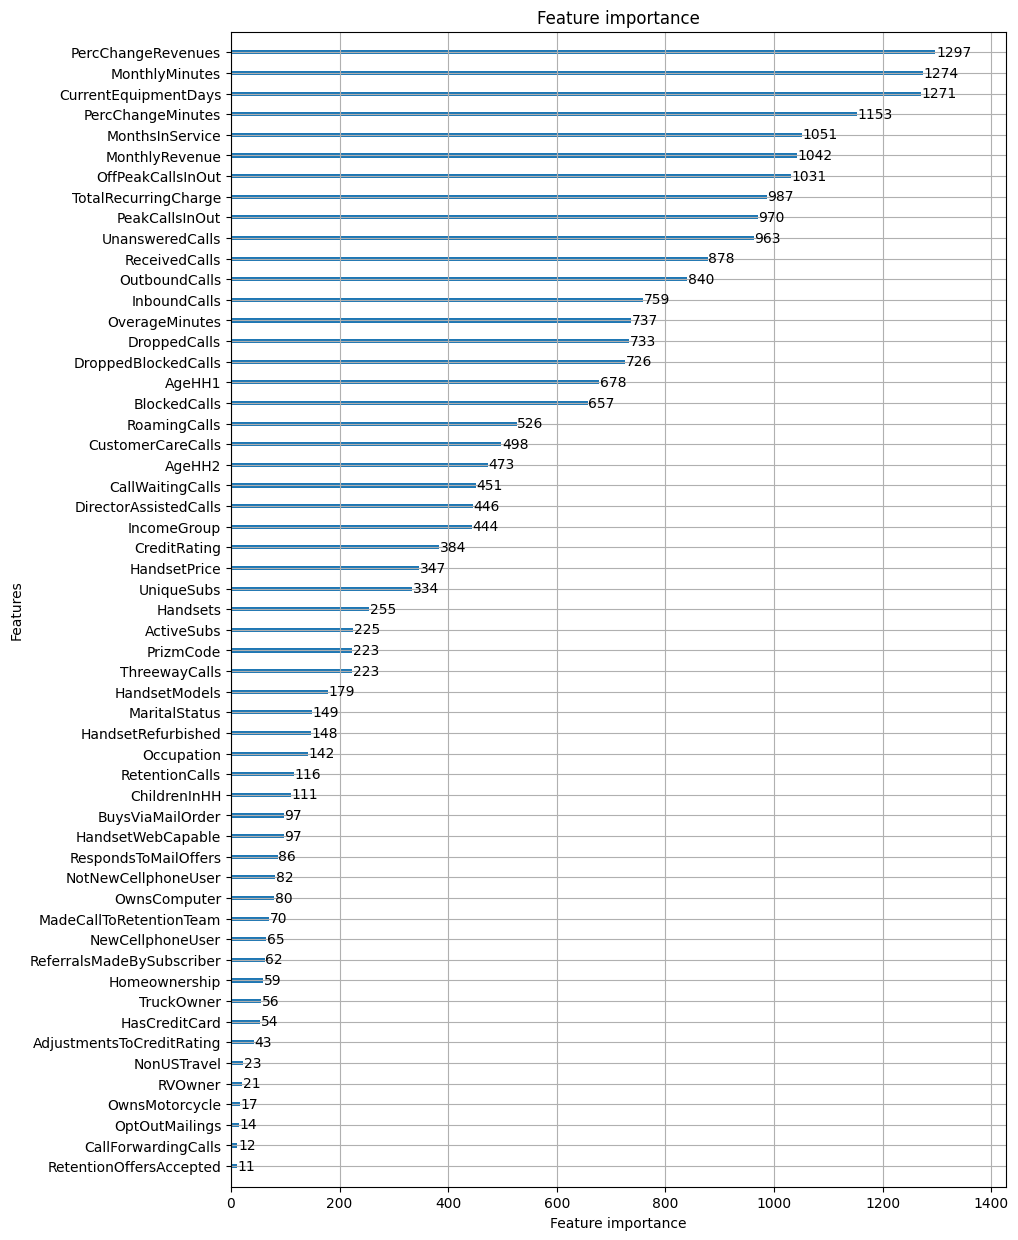

In [8]:
drop_na_train, temp = train_test_split(drop_na_data, test_size=0.4, random_state=0)
drop_na_valid, drop_na_test = train_test_split(temp, test_size=0.5, random_state=0)
lgbm = lightgbm.LGBMClassifier(
            **best_param,
            random_state=0,
            verbose=0
        )
lgbm.fit(
    drop_na_train.drop(columns=['Churn']), drop_na_train['Churn'],
    eval_set=[(drop_na_valid.drop(columns=['Churn']), drop_na_valid['Churn'])]
)
plt.rcParams["figure.figsize"] = (10, 15)
lightgbm.plot_importance(lgbm)


##### 중요도가 낮은 Feature부터 하나씩 제거하면서 비교 

In [9]:
importance_data = pd.DataFrame({'importance':lgbm.feature_importances_}, index = lgbm.feature_names_in_)

In [10]:
importance_data = importance_data.sort_values('importance')
importance_data

,importance
RetentionOffersAccepted,11
CallForwardingCalls,12
OptOutMailings,14
OwnsMotorcycle,17
RVOwner,21
NonUSTravel,23
AdjustmentsToCreditRating,43
HasCreditCard,54
TruckOwner,56
Homeownership,59


In [11]:
drop_na_train, temp = train_test_split(drop_na_data, test_size=0.4, random_state=0)
drop_na_valid, drop_na_test = train_test_split(temp, test_size=0.5, random_state=0)
max_drop_count = 20
results = {}
for i in range(0, max_drop_count):
    col = importance_data.iloc[:i, :].index

    lgbm = lightgbm.LGBMClassifier(
                **best_param,
                random_state=0,
                verbose=0
            )
    lgbm.fit(
        drop_na_train.drop(columns=['Churn']).drop(columns=col), drop_na_train['Churn'],
        eval_set=[(drop_na_valid.drop(columns=['Churn']).drop(columns=col), drop_na_valid['Churn'])]
    )
    lgbm_predict = lgbm.predict(drop_na_test.drop(columns=['Churn']).drop(columns=col))
    results.update({
        f'drop {i+1} column':{
            classification_report(drop_na_test['Churn'], lgbm_predict)
        }
    })

In [12]:
for i, result in results.items():
    print(i)
    for r in result:
        print(r)


drop 1 column
              precision    recall  f1-score   support

           0       0.74      0.97      0.84      7126
           1       0.59      0.13      0.21      2825

    accuracy                           0.73      9951
   macro avg       0.66      0.55      0.52      9951
weighted avg       0.70      0.73      0.66      9951

drop 2 column
              precision    recall  f1-score   support

           0       0.74      0.97      0.84      7126
           1       0.60      0.13      0.21      2825

    accuracy                           0.73      9951
   macro avg       0.67      0.55      0.52      9951
weighted avg       0.70      0.73      0.66      9951

drop 3 column
              precision    recall  f1-score   support

           0       0.74      0.97      0.84      7126
           1       0.60      0.12      0.20      2825

    accuracy                           0.73      9951
   macro avg       0.67      0.54      0.52      9951
weighted avg       0.70      0.7